In [1]:
import pandas as pd
import utils
import warnings
import os
import skimage.util
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
genes = ["YAP1", "CORO2A", "CORO2B", "GMIP"]

### Read Profiles

In [3]:
orf_metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol"],
)

orf_profiles_with_feature_names_df = utils.consensus(
    pd.read_parquet("../profiles/profiles_wellpos_cc_var_mad_outlier_orf.parquet")
    .merge(orf_metadata_df, on="Metadata_JCP2022", how="inner")
    .query('Metadata_Symbol in @genes'),
    "Metadata_Symbol",
)

orf_profiles_with_feature_names_df.head()

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_4,BR00121552,J23,JCP2022_903067,GMIP,-4.215556,0.768919,-0.627263,1.150167,-0.505792,...,-2.115924,-2.093490,-2.104401,-2.089226,-2.076241,-2.106389,-2.092737,-2.098063,-2.101731,-2.099421
1,source_4,BR00123506,L11,JCP2022_907099,CORO2B,1.163795,0.041725,1.337077,-0.415227,1.323441,...,-1.020270,-1.028888,-1.038020,-1.044206,-1.055027,-1.037163,-1.041014,-1.046899,-1.041324,-1.033682
2,source_4,BR00123517,C16,JCP2022_906671,CORO2A,1.054504,0.553273,-0.068892,0.451936,-0.421768,...,-0.402102,-0.371214,-0.430871,-0.409410,-0.412219,-0.426773,-0.421468,-0.393912,-0.391265,-0.417312
3,source_4,BR00126520,G07,JCP2022_907106,YAP1,1.606215,2.225155,0.369793,-0.549316,0.141265,...,-0.937797,-0.958488,-1.034979,-1.001840,-1.041748,-0.984161,-0.978684,-0.960774,-0.990483,-0.959312


In [4]:
feature_names = utils.get_featurecols(orf_profiles_with_feature_names_df)

feature_name_interpretation_df = pd.DataFrame()

for feature_name in feature_names:
    df = pd.DataFrame(utils.parse_cp_features(feature_name), index=[0])
    feature_name_interpretation_df = pd.concat([feature_name_interpretation_df, df], ignore_index=True)

feature_name_interpretation_df.head()

,feature,compartment,feature_group,feature_type,channel
0,Cells_AreaShape_Area,Cells,AreaShape,Area,XNONE
1,Cells_AreaShape_BoundingBoxArea,Cells,AreaShape,BoundingBoxArea,XNONE
2,Cells_AreaShape_BoundingBoxMaximum_X,Cells,AreaShape,BoundingBoxMaximum,XNONE
3,Cells_AreaShape_BoundingBoxMaximum_Y,Cells,AreaShape,BoundingBoxMaximum,XNONE
4,Cells_AreaShape_BoundingBoxMinimum_X,Cells,AreaShape,BoundingBoxMinimum,XNONE


In [5]:
feature_group = "AreaShape"
feature_group_list = ["Texture", "Intensity", "RadialDistribution"]
compartments = ["Cells", "Cytoplasm", "Nuclei"]
channels = ["DNA", "RNA", "Mito", "ER", "AGP"]

In [6]:
compartment_feature_group_df = pd.DataFrame()

for compartment in compartments:
    feature_cols = (
        feature_name_interpretation_df.query("feature_group==@feature_group")
        .query("compartment==@compartment")
        .feature.to_list()
    )
    feature_values = orf_profiles_with_feature_names_df[feature_cols].copy().values
    id = list(orf_profiles_with_feature_names_df["Metadata_Symbol"])

    cosine_sim = utils.cosine_similarity(id, feature_values).values

    median_sim = np.median(cosine_sim[np.triu_indices(cosine_sim.shape[0], k=1)])

    df = pd.DataFrame(
        {
            "Compartment": compartment,
            "Feature_group": feature_group,
            "Similarity": median_sim,
        },
        index=[0],
    )

    compartment_feature_group_df = pd.concat(
        [compartment_feature_group_df, df], ignore_index=True
    )

compartment_feature_group_df = compartment_feature_group_df.pivot(
    index="Feature_group", columns="Compartment", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
print(compartment_feature_group_df.to_markdown())

| Feature_group   |     Cells |   Cytoplasm |   Nuclei |
|:----------------|----------:|------------:|---------:|
| AreaShape       | -0.084615 |  -0.0488807 | 0.829156 |


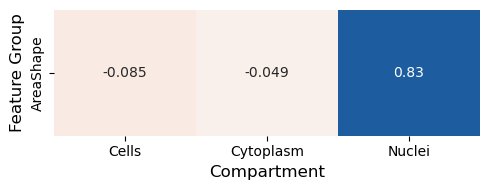

In [8]:
n_row = compartment_feature_group_df.shape[0]
n_col = compartment_feature_group_df.shape[1]
fig_width = n_row + 4
fig_height = 2

plt.figure(figsize = (fig_width, fig_height))

f = sns.heatmap(
    compartment_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
    cbar=None,
)

f.set(xlabel="Compartment", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()
plt.savefig("figures/YAP1_subset_area_size_compartment.png")
plt.savefig("figures/YAP1_subset_area_size_compartment.svg")

In [9]:
channel_feature_group_df = pd.DataFrame()

for channel in channels:
    for feature_group in feature_group_list:
        feature_cols = (
            feature_name_interpretation_df.query("feature_group==@feature_group")
            .query("channel==@channel")
            .feature.to_list()
        )
        feature_values = orf_profiles_with_feature_names_df[feature_cols].copy().values
        id = list(orf_profiles_with_feature_names_df["Metadata_Symbol"])

        cosine_sim = utils.cosine_similarity(id, feature_values).values

        median_sim = np.median(cosine_sim[np.triu_indices(cosine_sim.shape[0], k=1)])

        df = pd.DataFrame(
            {
                "Channel": channel,
                "Feature_group": feature_group,
                "Similarity": median_sim,
            },
            index=[0],
        )

        channel_feature_group_df = pd.concat(
            [channel_feature_group_df, df], ignore_index=True
        )

channel_feature_group_df = channel_feature_group_df.pivot(
    index="Feature_group", columns="Channel", values="Similarity"
)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
print(channel_feature_group_df.to_markdown())

| Feature_group      |      AGP |      DNA |       ER |       Mito |      RNA |
|:-------------------|---------:|---------:|---------:|-----------:|---------:|
| Intensity          | 0.338118 | 0.170356 | 0.292881 | -0.0390663 | 0.466935 |
| RadialDistribution | 0.39262  | 0.718204 | 0.423729 |  0.368032  | 0.644241 |
| Texture            | 0.456424 | 0.208514 | 0.197651 | -0.209481  | 0.367863 |


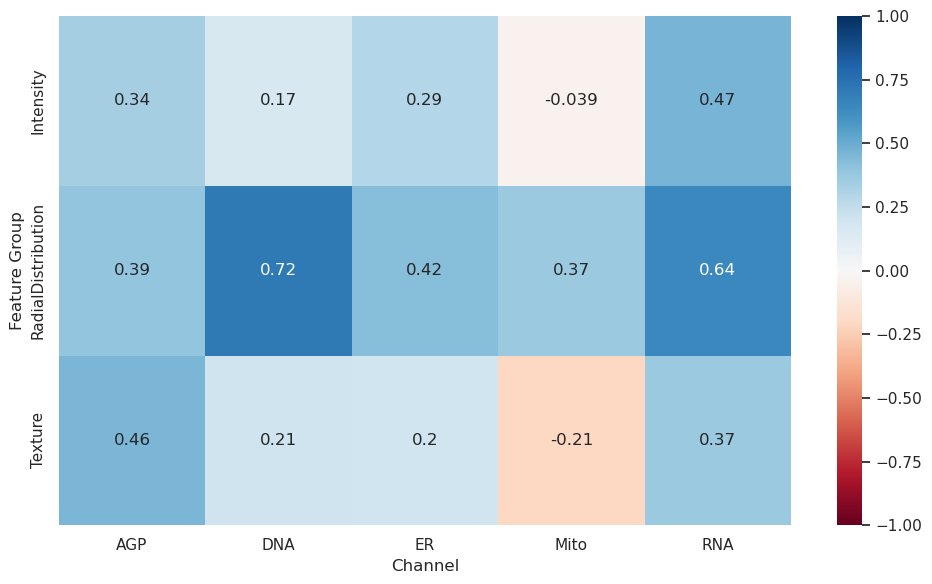

In [11]:
sns.set(font_scale=1)
plt.figure(figsize = (fig_width*2, fig_height*3))


f = sns.heatmap(
    channel_feature_group_df,
    cmap="RdBu",
    vmin=-1,
    vmax=1,
    xticklabels=True,
    yticklabels=True,
    annot=True,
)

f.set(xlabel="Channel", ylabel="Feature Group")

f.xaxis.label.set_size(12)
f.yaxis.label.set_size(12)
plt.tight_layout()
plt.savefig("figures/YAP1_subset_feature_group_channel.png")
plt.savefig("figures/YAP1_subset_feature_group_channel.svg")

In [12]:
channels = ["DNA", "AGP", "Mito", "ER", "RNA"]
channel_perturbation_df = pd.DataFrame()
overwrite = False

In [13]:
orf_profiles_with_feature_names_df

,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Symbol,Cells_AreaShape_Area,Cells_AreaShape_BoundingBoxArea,Cells_AreaShape_BoundingBoxMaximum_X,Cells_AreaShape_BoundingBoxMaximum_Y,Cells_AreaShape_BoundingBoxMinimum_X,...,Nuclei_Texture_Variance_RNA_10_02_256,Nuclei_Texture_Variance_RNA_10_03_256,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256
0,source_4,BR00121552,J23,JCP2022_903067,GMIP,-4.215556,0.768919,-0.627263,1.150167,-0.505792,...,-2.115924,-2.093490,-2.104401,-2.089226,-2.076241,-2.106389,-2.092737,-2.098063,-2.101731,-2.099421
1,source_4,BR00123506,L11,JCP2022_907099,CORO2B,1.163795,0.041725,1.337077,-0.415227,1.323441,...,-1.020270,-1.028888,-1.038020,-1.044206,-1.055027,-1.037163,-1.041014,-1.046899,-1.041324,-1.033682
2,source_4,BR00123517,C16,JCP2022_906671,CORO2A,1.054504,0.553273,-0.068892,0.451936,-0.421768,...,-0.402102,-0.371214,-0.430871,-0.409410,-0.412219,-0.426773,-0.421468,-0.393912,-0.391265,-0.417312
3,source_4,BR00126520,G07,JCP2022_907106,YAP1,1.606215,2.225155,0.369793,-0.549316,0.141265,...,-0.937797,-0.958488,-1.034979,-1.001840,-1.041748,-0.984161,-0.978684,-0.960774,-0.990483,-0.959312


In [14]:
channel_perturbation_df = (
    orf_profiles_with_feature_names_df[
        [
            "Metadata_JCP2022",
            "Metadata_Source",
            "Metadata_Plate",
            "Metadata_Well",
            "Metadata_Symbol",
        ]
    ]
    .copy()
    .assign(pert_type="trt", modality="ORF")
)

channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality
0,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF
1,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF
2,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF
3,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF


In [15]:
# Add a Lucifersase well from the YAP1 plate

YAP1_plate = channel_perturbation_df.query(
    'Metadata_Symbol == "YAP1"'
).Metadata_Plate.values[0]

well = pd.read_csv("../datasets/metadata/well.csv.gz").query(
    "Metadata_Plate == @YAP1_plate"
).merge(orf_metadata_df, on="Metadata_JCP2022").query('Metadata_Symbol=="LUCIFERASE"')

well = well.sample(1, random_state=12527).assign(pert_type="negcon", modality="ORF")

channel_perturbation_df = pd.concat(
    [channel_perturbation_df, well], ignore_index=True
)

channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality
0,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF
1,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF
2,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF
3,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF
4,JCP2022_915130,source_4,BR00126520,J02,LUCIFERASE,negcon,ORF


In [16]:
df = pd.DataFrame()

for channel in channels:
    df = pd.concat(
        [
            df,
            channel_perturbation_df.assign(channel=channel),
        ],
        ignore_index=True,
    )

channel_perturbation_df = df.copy()
channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality,channel
0,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,DNA
1,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,DNA
2,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF,DNA
3,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,DNA
4,JCP2022_915130,source_4,BR00126520,J02,LUCIFERASE,negcon,ORF,DNA
5,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,AGP
6,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,AGP
7,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF,AGP
8,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,AGP
9,JCP2022_915130,source_4,BR00126520,J02,LUCIFERASE,negcon,ORF,AGP


Add Batch information to the metadata

In [17]:
plate_df = pd.read_csv("../datasets/metadata/plate.csv.gz", usecols=["Metadata_Batch", "Metadata_Plate"])

channel_perturbation_df = channel_perturbation_df.merge(plate_df, on="Metadata_Plate", how="left")

channel_perturbation_df

,Metadata_JCP2022,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Symbol,pert_type,modality,channel,Metadata_Batch
0,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,DNA,2021_05_31_Batch2
1,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,DNA,2021_05_10_Batch3
2,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF,DNA,2021_05_17_Batch4
3,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,DNA,2021_08_09_Batch11
4,JCP2022_915130,source_4,BR00126520,J02,LUCIFERASE,negcon,ORF,DNA,2021_08_09_Batch11
5,JCP2022_903067,source_4,BR00121552,J23,GMIP,trt,ORF,AGP,2021_05_31_Batch2
6,JCP2022_907099,source_4,BR00123506,L11,CORO2B,trt,ORF,AGP,2021_05_10_Batch3
7,JCP2022_906671,source_4,BR00123517,C16,CORO2A,trt,ORF,AGP,2021_05_17_Batch4
8,JCP2022_907106,source_4,BR00126520,G07,YAP1,trt,ORF,AGP,2021_08_09_Batch11
9,JCP2022_915130,source_4,BR00126520,J02,LUCIFERASE,negcon,ORF,AGP,2021_08_09_Batch11


Download images from S3

In [18]:
if overwrite:
    os.system("rm -rf images")
    os.system("mkdir images")
    for jcpid in channel_perturbation_df.Metadata_JCP2022.unique():
        os.system(f"mkdir images/{jcpid}")
    utils.download_images(channel_perturbation_df)

Create Montage

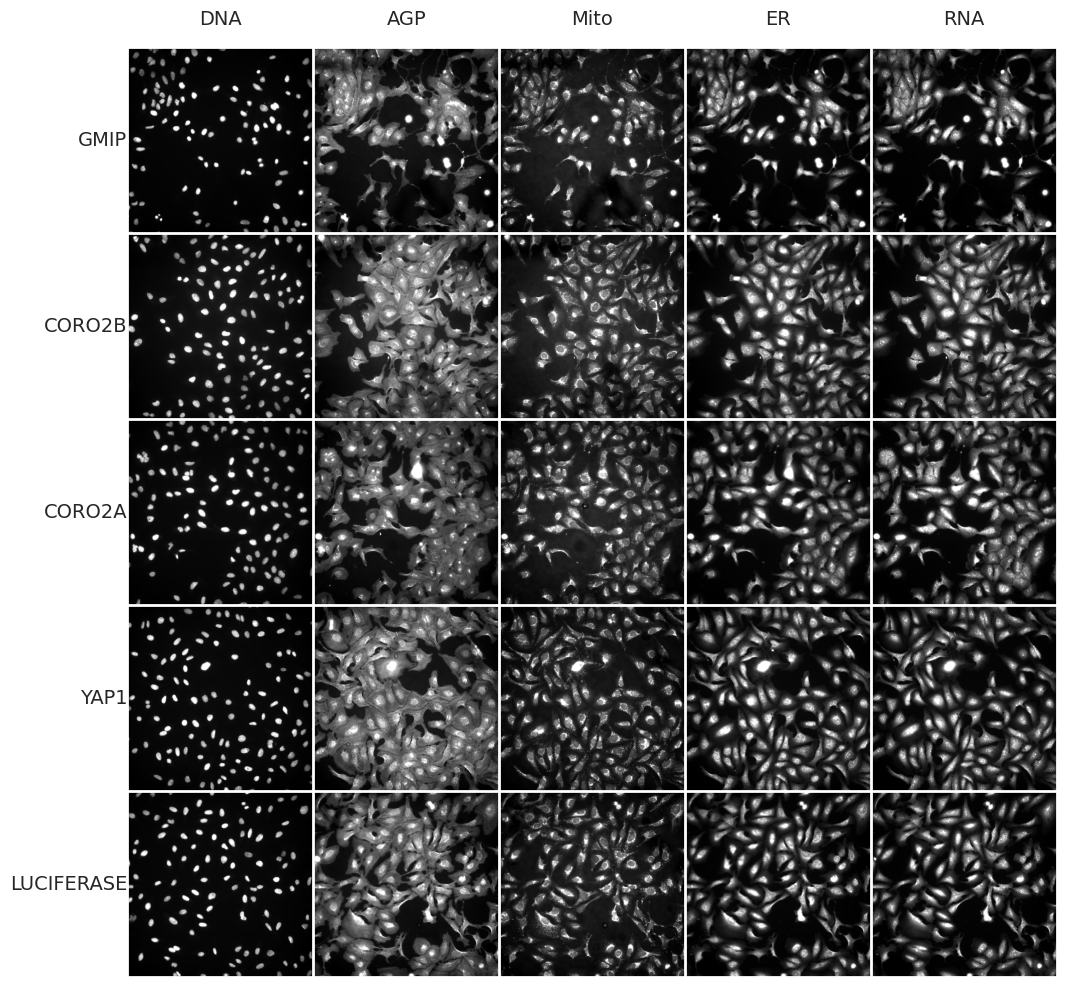

In [19]:
images = []
row_labels = []
col_labels = channels


for perturbation in channel_perturbation_df.Metadata_JCP2022.unique():
    row_labels.append(channel_perturbation_df.query(f"Metadata_JCP2022 == '{perturbation}'").Metadata_Symbol.unique()[0])
    for channel in channels:
        df = channel_perturbation_df.query(f"Metadata_JCP2022 == '{perturbation}' and channel == '{channel}'")
        for row in df.itertuples():
            filename = (
                f"images/{perturbation}/{perturbation}_{channel}.tiff"
            )
            img = skimage.io.imread(filename)
            img = utils.brighten_contrast_stretch(img)
            # img = utils.standardize_image(img)
            images.append(img)

grid_shape = (5, 5)

fig = utils.create_facet_grid_montage(
    images, row_labels, col_labels, grid_shape,
)

# Display the figure
plt.show()


#Save the figure
fig.savefig("figures/facet_grid_montage_YAP1.png", dpi=300, bbox_inches="tight")

#### Compared to negcon, features from which compartment are enriched?

In [20]:
orf_df = pd.read_parquet('../10.feature-wise-analyses/input/orf_feat_pert_pval_mwu.parquet').set_index('Feature')

cols = channel_perturbation_df.query('Metadata_Symbol!="LUCIFERASE"').Metadata_JCP2022.unique()

orf_df = orf_df[cols]

orf_df.head()

,JCP2022_903067,JCP2022_907099,JCP2022_906671,JCP2022_907106
Feature,,,,
Cells_AreaShape_Area,0.057649,0.023465,0.668170,0.85424
Cells_AreaShape_BoundingBoxArea,0.043297,0.023465,0.158996,0.85424
Cells_AreaShape_BoundingBoxMaximum_X,0.125786,0.854240,0.032089,0.66817
Cells_AreaShape_BoundingBoxMaximum_Y,0.951170,0.425983,0.759463,0.95117
Cells_AreaShape_BoundingBoxMinimum_X,0.158996,0.759463,0.158996,0.85424


In [21]:
orf_df = (
    orf_df.stack()
    .reset_index()
    .rename(columns={"level_1": "Metadata_JCP2022", 0: "pval"})
    .query("pval < 0.05")
)

orf_df = orf_df.groupby("Metadata_JCP2022").Feature.apply(list).reset_index()

orf_df.head()

,Metadata_JCP2022,Feature
0,JCP2022_903067,"[Cells_AreaShape_BoundingBoxArea, Cells_AreaSh..."
1,JCP2022_906671,"[Cells_AreaShape_BoundingBoxMaximum_X, Cells_A..."
2,JCP2022_907099,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin..."
3,JCP2022_907106,"[Cells_AreaShape_Solidity, Cells_AreaShape_Zer..."


In [22]:
for channel in channels:
    orf_df = orf_df.assign(
        count=lambda x: x.Feature.apply(
            lambda y: sum([1 if channel in i else 0 for i in y]) 
        )
    ).rename(columns={"count": f"{channel}_count"})

orf_df.head()

,Metadata_JCP2022,Feature,DNA_count,AGP_count,Mito_count,ER_count,RNA_count
0,JCP2022_903067,"[Cells_AreaShape_BoundingBoxArea, Cells_AreaSh...",77,111,56,84,46
1,JCP2022_906671,"[Cells_AreaShape_BoundingBoxMaximum_X, Cells_A...",164,211,25,26,22
2,JCP2022_907099,"[Cells_AreaShape_Area, Cells_AreaShape_Boundin...",52,6,3,22,41
3,JCP2022_907106,"[Cells_AreaShape_Solidity, Cells_AreaShape_Zer...",302,36,33,284,243


In [23]:
orf_df["cluster"] = "YAP1"

In [24]:
orf_feature_count = (
    orf_df[
        ["cluster", "ER_count", "Mito_count", "DNA_count", "AGP_count", "RNA_count"]
    ]
    .groupby("cluster")
    .apply(lambda x: x.mean(numeric_only=True))
)

orf_feature_count.head()

,ER_count,Mito_count,DNA_count,AGP_count,RNA_count
cluster,,,,,
YAP1,104.0,29.25,148.75,91.0,88.0


In [25]:
orf_feature_percent = orf_feature_count.div(
    orf_feature_count.sum(axis=1), axis=0
).rename(
    columns={
        "ER_count": "ER_percent",
        "Mito_count": "Mito_percent",
        "DNA_count": "DNA_percent",
        "AGP_count": "AGP_percent",
        "RNA_count": "RNA_percent",
    }
)

orf_feature_percent

,ER_percent,Mito_percent,DNA_percent,AGP_percent,RNA_percent
cluster,,,,,
YAP1,0.225597,0.063449,0.322668,0.197397,0.190889


In [26]:
print(orf_feature_percent.to_markdown())

| cluster   |   ER_percent |   Mito_percent |   DNA_percent |   AGP_percent |   RNA_percent |
|:----------|-------------:|---------------:|--------------:|--------------:|--------------:|
| YAP1      |     0.225597 |       0.063449 |      0.322668 |      0.197397 |      0.190889 |
